# Pipeline for High-z Radio Galaxies 08: Understanding application of full pipeline on confusion matrices

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import mpl_scatter_density
import squarify
from chainconsumer import ChainConsumer
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

In [4]:
def predict_star(catalog_df, star_model, cal_str_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    pred_probs = cal_str_model.predict(catalog_df.loc[:, 'Score_0'])
    cal_class  = np.array(pred_probs < (1 - cal_threshold)).astype(int)
    catalog_df['Prob_no_star']  = pred_probs
    catalog_df['pred_star_cal'] = cal_class
    return catalog_df

In [5]:
def predict_AGN_gal(catalog_df, AGN_gal_model, cal_AGN_gal_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(AGN_gal_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
    catalog_df.loc[:, 'Score_AGN'] = np.around(catalog_df.loc[:, 'Score_AGN'], decimals=8)
    pred_probs = cal_AGN_gal_model.predict(catalog_df.loc[:, 'Score_AGN'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_AGN']       = pred_probs
    catalog_df['pred_class_cal'] = cal_class
    return catalog_df

In [6]:
def predict_radio_det(catalog_df, radio_model, cal_radio_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(radio_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
    catalog_df.loc[:, 'Score_radio'] = np.around(catalog_df.loc[:, 'Score_radio'], decimals=8)
    pred_probs = cal_radio_model.predict(catalog_df.loc[:, 'Score_radio'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_radio']     = pred_probs
    catalog_df['pred_radio_cal'] = cal_class
    return catalog_df

In [7]:
def predict_z_full(catalog_df, redshift_model):
    catalog_df = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    catalog_df = catalog_df.rename(columns={'Label': 'pred_Z'})
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=6)
    return catalog_df

In [8]:
def predict_z_high(catalog_df, redshift_model, z_lim, z_tol):
    catalog_df    = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    filter_pred_z = catalog_df.loc[:, 'pred_Z'] >= (z_lim + z_tol)
    catalog_df.loc[:, 'pred_Z'] = catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, catalog_df.loc[filter_pred_z, 'Label'])
    catalog_df    = catalog_df.drop(columns=['Label'])
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=6)
    return catalog_df

---

## Reading data

Flags.

In [9]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False
use_calibration     = True
use_imputed         = True

In [10]:
used_area           = 'HETDEX'      # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'validation'  # 'training', 'test', 'train_test', 'calibration', 'validation', 'known', 'unknown', 'all'
S82_subset          = 'known'       # 'known', 'unknown', 'all'
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies). For most plots, only use False

In [11]:
# if used_area == 'HETDEX':
#     HETDEX_subset = 'Validation'  # Validation, Training, Test, Test+Train, Calibration

In [12]:
if use_imputed:
    file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
    imp_string          = '_imputed'
if not use_imputed:
    file_name_dict      = {'S82': gv.file_non_imp_S82, 'HETDEX': gv.file_non_imp_HETDEX, 'COSMOS': gv.file_non_imp_COSMOS}
    imp_string          = '_nonimputed'
file_name_HETDEX        = file_name_dict['HETDEX']
file_name_S82           = file_name_dict['S82']

In [13]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                       'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag',\
                       'NUVmag', 'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                       'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                       'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag',\
                       'NUVmag', 'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [14]:
full_catalog_HETDEX_df  = pd.read_hdf(gv.cat_path + file_name_HETDEX, key='df').drop(columns=feats_2_disc_HETDEX)
full_catalog_S82_df     = pd.read_hdf(gv.cat_path + file_name_S82,    key='df').drop(columns=feats_2_disc_S82)

In [15]:
full_catalog_S82_df.loc[:, 'LOFAR_detect'] = full_catalog_S82_df.loc[:, 'VLAS82_detect'].copy()
full_catalog_S82_df = full_catalog_S82_df.drop(columns=['VLAS82_detect'])

In [16]:
print(f'Using data from both fields: HETDEX and Stripe 82')

Using data from both fields: HETDEX and Stripe 82


Create features with class and combined redshift.

In [17]:
full_catalog_HETDEX_df['class']                   = full_catalog_HETDEX_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed_HETDEX                       = np.array(full_catalog_HETDEX_df.loc[:, 'is_AGN'] == 1) \
                                                    | np.array(full_catalog_HETDEX_df.loc[:, 'is_gal'] == 1)
full_catalog_HETDEX_df.loc[~filter_non_confirmed_HETDEX, 'class'] = 0.5
idx_non_Z_HETDEX                                  = full_catalog_HETDEX_df.loc[:, 'Z'].where(full_catalog_HETDEX_df.loc[:, 'Z'] > 0).isna()
full_catalog_HETDEX_df.loc[idx_non_Z_HETDEX, 'Z'] = full_catalog_HETDEX_df.loc[:, 'Z'].mask(idx_non_Z_HETDEX, full_catalog_HETDEX_df.loc[idx_non_Z_HETDEX, 'zsp'])

full_catalog_S82_df['class']            = full_catalog_S82_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed_S82                = np.array(full_catalog_S82_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_S82_df.loc[:, 'is_gal'] == 1)
full_catalog_S82_df.loc[~filter_non_confirmed_S82, 'class'] = 0.5
idx_non_Z_S82                           = full_catalog_S82_df.loc[:, 'Z'].where(full_catalog_S82_df.loc[:, 'Z'] > 0).isna()
full_catalog_S82_df.loc[idx_non_Z_S82, 'Z'] = full_catalog_S82_df.loc[:, 'Z'].mask(idx_non_Z_S82, full_catalog_S82_df.loc[idx_non_Z_S82, 'zsp'])

In [18]:
for col in full_catalog_HETDEX_df.columns:
    if full_catalog_HETDEX_df.loc[:, col].dtype == 'float64':
        full_catalog_HETDEX_df.loc[:, col] = full_catalog_HETDEX_df.loc[:, col].astype('float32')
for col in full_catalog_S82_df.columns:
    if full_catalog_S82_df.loc[:, col].dtype == 'float64':
        full_catalog_S82_df.loc[:, col] = full_catalog_S82_df.loc[:, col].astype('float32')

In [19]:
HETDEX_known_filter     = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 0) | np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1)
S82_known_filter        = np.array(full_catalog_S82_df.loc[:, 'class'] == 0)    | np.array(full_catalog_S82_df.loc[:, 'class'] == 1)

In [20]:
HETDEX_true_rAGN_filter = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)
S82_true_rAGN_filter    = np.array(full_catalog_S82_df.loc[:, 'class'] == 1)    & np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)

Always copy HETDEX unknown for final plots

In [21]:
unknown_HETDEX_df = full_catalog_HETDEX_df.loc[~HETDEX_known_filter].copy()

In [22]:
if HETDEX_subset == 'unknown':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[~HETDEX_known_filter]
elif HETDEX_subset == 'known':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
elif HETDEX_subset == 'training':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, full_catalog_HETDEX_df, _, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'test':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, full_catalog_HETDEX_df, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'train_test':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    full_catalog_HETDEX_df, _, _, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'calibration':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, _, full_catalog_HETDEX_df, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
elif HETDEX_subset == 'validation':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, _, _, full_catalog_HETDEX_df = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=True)
else:
    pass

In [23]:
if S82_subset == 'unknown':
    full_catalog_S82_df = full_catalog_S82_df.loc[~S82_known_filter]
elif S82_subset == 'known':
    full_catalog_S82_df = full_catalog_S82_df.loc[S82_known_filter]
else:
    pass

In [24]:
print('Shape of used data in HETDEX')
print('-' * 40)
print(f'Selected sub-set is: {HETDEX_subset}')
print(f'Its shape is:        {full_catalog_HETDEX_df.shape}')
print('-' * 40)
print()

Shape of used data in HETDEX
----------------------------------------
Selected sub-set is: validation
Its shape is:        (16682, 95)
----------------------------------------



In [25]:
print('Shape of used data in Stripe 82')
print('-' * 40)
print(f'Selected sub-set is: {S82_subset}')
print(f'Its shape is:        {full_catalog_S82_df.shape}')
print('-' * 40)
print()

Shape of used data in Stripe 82
----------------------------------------
Selected sub-set is: known
Its shape is:        (3304, 93)
----------------------------------------



Discard minor features.

In [26]:
full_catalog_HETDEX_df  = full_catalog_HETDEX_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'RA_ICRS', 'DE_ICRS', 'Name', 'spCl'])
full_catalog_S82_df     = full_catalog_S82_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'RA_ICRS', 'DE_ICRS', 'Name', 'spCl'])

In [27]:
HETDEX_AGN_filter       = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1)
S82_AGN_filter          = np.array(full_catalog_S82_df.loc[:, 'class'] == 1)
HETDEX_gal_filter       = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 0)
S82_gal_filter          = np.array(full_catalog_S82_df.loc[:, 'class'] == 0)

In [28]:
HETDEX_radio_filter     = np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)
S82_radio_filter        = np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)
HETDEX_noradio_filter   = np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 0)
S82_noradio_filter      = np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 0)

In [29]:
HETDEX_known_filter     = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 0) | np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1)
S82_known_filter        = np.array(full_catalog_S82_df.loc[:, 'class'] == 0)    | np.array(full_catalog_S82_df.loc[:, 'class'] == 1)

In [30]:
HETDEX_true_rAGN_filter = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)
S82_true_rAGN_filter    = np.array(full_catalog_S82_df.loc[:, 'class'] == 1)    & np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)

---

### Load models

In [31]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [32]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.cal_star_thresh  / (1 - gv.cal_star_thresh))
threshold_AGN_logit      = np.log(gv.cal_AGN_thresh   / (1 - gv.cal_AGN_thresh))
threshold_radio_logit    = np.log(gv.cal_radio_thresh / (1 - gv.cal_radio_thresh))

In [33]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_HETDEX_df = predict_star(full_catalog_HETDEX_df, star_clf, cal_star_clf, gv.star_thresh, gv.cal_str_thresh)
    full_catalog_S82_df  = predict_star(full_catalog_S82_df,  star_clf, cal_star_clf, gv.star_thresh, gv.cal_str_thresh)
elif not use_zeroth_model:
    full_catalog_HETDEX_df['pred_star']     = 0
    full_catalog_HETDEX_df['Score_no_star'] = 1
    full_catalog_HETDEX_df['Prob_no_star']  = 1
    full_catalog_HETDEX_df['pred_star_cal'] = 0
    full_catalog_S82_df['pred_star']      = 0
    full_catalog_S82_df['pred_star_cal']  = 0
    full_catalog_S82_df['Score_no_star']  = 1
    full_catalog_S82_df['Prob_no_star']   = 1

In [34]:
full_catalog_HETDEX_df = predict_AGN_gal(full_catalog_HETDEX_df, AGN_gal_clf, cal_AGN_gal_clf, gv.AGN_thresh, gv.cal_AGN_thresh)
full_catalog_S82_df    = predict_AGN_gal(full_catalog_S82_df,  AGN_gal_clf, cal_AGN_gal_clf, gv.AGN_thresh, gv.cal_AGN_thresh)

In [35]:
full_catalog_HETDEX_df = predict_radio_det(full_catalog_HETDEX_df, radio_det_clf, cal_radio_det_clf, gv.radio_thresh, gv.cal_radio_thresh)
full_catalog_S82_df    = predict_radio_det(full_catalog_S82_df,  radio_det_clf, cal_radio_det_clf, gv.radio_thresh, gv.cal_radio_thresh)

In [36]:
full_catalog_HETDEX_df = predict_z_full(full_catalog_HETDEX_df, redshift_reg)
full_catalog_S82_df    = predict_z_full(full_catalog_S82_df,  redshift_reg)  

In [37]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_HETDEX_df = predict_z_high(full_catalog_HETDEX_df, redshift_reg_2, gv.high_z_limit, redshift_tol)
    full_catalog_S82_df    = predict_z_high(full_catalog_S82_df,  redshift_reg_2, gv.high_z_limit, redshift_tol)

In [38]:
full_catalog_HETDEX_df['is_rAGN']   = (np.array(full_catalog_HETDEX_df.loc[:, 'class']        == 1) &\
                                np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)).astype(int)
full_catalog_HETDEX_df['pred_rAGN'] = (np.array(full_catalog_HETDEX_df.loc[:, 'pred_star']    == 0) &\
                                np.array(full_catalog_HETDEX_df.loc[:, 'pred_class']   == 1) &\
                                np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio']   == 1)).astype(int)
full_catalog_HETDEX_df['pred_rAGN_prob'] = (np.array(full_catalog_HETDEX_df.loc[:, 'pred_star_cal']  == 0) &\
                                     np.array(full_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 1) &\
                                     np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal'] == 1)).astype(int)

full_catalog_S82_df['is_rAGN']   = (np.array(full_catalog_S82_df.loc[:, 'class']        == 1) &\
                                np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)).astype(int)
full_catalog_S82_df['pred_rAGN'] = (np.array(full_catalog_S82_df.loc[:, 'pred_star']    == 0) &\
                                np.array(full_catalog_S82_df.loc[:, 'pred_class']   == 1) &\
                                np.array(full_catalog_S82_df.loc[:, 'pred_radio']   == 1)).astype(int)
full_catalog_S82_df['pred_rAGN_prob'] = (np.array(full_catalog_S82_df.loc[:, 'pred_star_cal']  == 0) &\
                                     np.array(full_catalog_S82_df.loc[:, 'pred_class_cal'] == 1) &\
                                     np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal'] == 1)).astype(int)

In [39]:
np.sum(np.array(full_catalog_HETDEX_df.loc[:, 'class']      == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1))

1618

In [40]:
HETDEX_pAGN_filter      = np.array(full_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 1)
S82_pAGN_filter         = np.array(full_catalog_S82_df.loc[:, 'pred_class_cal'] == 1)
HETDEX_pgal_filter      = np.array(full_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 0)
S82_pgal_filter         = np.array(full_catalog_S82_df.loc[:, 'pred_class_cal'] == 0)

In [41]:
HETDEX_pradio_filter    = np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal'] == 1)
S82_pradio_filter       = np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal'] == 1)
HETDEX_pnoradio_filter  = np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal'] == 0)
S82_pnoradio_filter     = np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal'] == 0)

In [42]:
HETDEX_pred_rAGN_filter = np.array(full_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal'] == 1)
S82_pred_rAGN_filter    = np.array(full_catalog_S82_df.loc[:, 'pred_class_cal'] == 1)    & np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal'] == 1)

In [43]:
HETDEX_pred_AGN_norad_filter = np.array(full_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 1) & np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal'] == 0)
S82_pred_AGN_norad_filter    = np.array(full_catalog_S82_df.loc[:, 'pred_class_cal'] == 1)    & np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal'] == 0)

In [44]:
# filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
# filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
# total_size              = len(full_catalog_df)
# filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
# num_AGN_t               = np.sum(filter_AGN_t)
# num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
# num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
# num_radio_AGN_t         = np.sum(filter_radio_AGN_t)
# 
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'pred_class_cal']      == 1) &\
#                             np.array(full_catalog_df.loc[:, 'pred_radio_cal']    == 1)
# filter_AGN_p            = np.array(full_catalog_df.loc[:, 'pred_class_cal']      == 1)
# filter_radio_p          = np.array(full_catalog_df.loc[:, 'pred_radio_cal']      == 1)
# num_AGN_p               = np.sum(filter_AGN_p)
# num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0))
# num_radio_p             = np.sum(filter_radio_p)
# num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

In [45]:
# filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
# filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
# total_size              = len(full_catalog_df)
# filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
# num_AGN_t               = np.sum(filter_AGN_t)
# num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
# num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
# num_radio_AGN_t         = np.sum(filter_radio_AGN_t)
# 
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'pred_class_cal']      == 1) &\
#                             np.array(full_catalog_df.loc[:, 'pred_radio_cal']    == 1)
# filter_AGN_p            = np.array(full_catalog_df.loc[:, 'pred_class_cal']      == 1)
# filter_radio_p          = np.array(full_catalog_df.loc[:, 'pred_radio_cal']      == 1)
# num_AGN_p               = np.sum(filter_AGN_p)
# num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0))
# num_radio_p             = np.sum(filter_radio_p)
# num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

#### Add columns with classes as shown by TYPE column in MQC

MQC v7.4d says:

Legend of type/class:  
     ``Q = QSO, type-I broad-line core-dominated, 792372 of these.``  
     ``A = AGN, type-I Seyferts/host-dominated, 41983 of these.``  
     ``B = BL Lac type object, 2744 of these.``  
     ``L = lensed quasar extra image, only 66 of these in this optical data.``  
     ``K = NLQSO, type-II narrow-line core-dominated, 5798 of these.``  
     ``N = NLAGN, type-II Seyferts/host-dominated, 39366 of these.  Includes an``  
                ``unquantified residue of legacy NELGs/ELGs/LINERs.``  
     ``R = radio association displayed.``  
     ``X = X-ray association displayed.``  
     ``2 = double radio lobes displayed (declared by data-driven algorithm).``  

QSO candidates (type starting with ``R/X/2``)  
Fully classified object (type starting with ``Q/A/B/K/N/L``)

In [46]:
MQC_types = ['Q', 'A', 'B', 'K', 'N', 'L', 'R', 'X', '2']
for type_val in MQC_types:
    full_catalog_HETDEX_df[f'is_{type_val}'] = np.array(full_catalog_HETDEX_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)).astype(int)
    full_catalog_S82_df[f'is_{type_val}'] = np.array(full_catalog_S82_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)).astype(int)

### Create confusion matrices and scores for all individual TYPEs of sources

In [47]:
cm_mat_MQC_filts_HETDEX = {}
cm_mat_MQC_filts_S82    = {}
cm_mat_MQC_HETDEX       = {}
cm_mat_MQC_S82          = {}
MCC_MQC          = {}
ACC_MQC          = {}
Fb_MQC           = {}
Recall_MQC       = {}

In [48]:
cm_mat_AGN_filter_HETDEX = np.array([[(np.array(full_catalog_HETDEX_df['class'] == 0)   & np.array(full_catalog_HETDEX_df['pred_class_cal'] == 0)),\
                                      (np.array(full_catalog_HETDEX_df['class'] == 0)   & np.array(full_catalog_HETDEX_df['pred_class_cal'] == 1))],\
                                     [(np.array(full_catalog_HETDEX_df['class'] == 1)   & np.array(full_catalog_HETDEX_df['pred_class_cal'] == 0)),\
                                      (np.array(full_catalog_HETDEX_df['class'] == 1)   & np.array(full_catalog_HETDEX_df['pred_class_cal'] == 1))]])

cm_mat_AGN_filter_S82    = np.array([[(np.array(full_catalog_S82_df['class'] == 0)   & np.array(full_catalog_S82_df['pred_class_cal'] == 0)),\
                                      (np.array(full_catalog_S82_df['class'] == 0)   & np.array(full_catalog_S82_df['pred_class_cal'] == 1))],\
                                     [(np.array(full_catalog_S82_df['class'] == 1)   & np.array(full_catalog_S82_df['pred_class_cal'] == 0)),\
                                      (np.array(full_catalog_S82_df['class'] == 1)   & np.array(full_catalog_S82_df['pred_class_cal'] == 1))]])

In [49]:
cm_mat_radio_filter_HETDEX = np.array([[(np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'LOFAR_detect'] == 0) &\
                                      np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'pred_radio_cal'] == 0)),\
                                     (np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'LOFAR_detect'] == 0) &\
                                      np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'pred_radio_cal'] == 1))],\
                                    [(np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'LOFAR_detect'] == 1) &\
                                      np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'pred_radio_cal'] == 0)),\
                                     (np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'LOFAR_detect'] == 1) &\
                                      np.array(full_catalog_HETDEX_df.loc[HETDEX_pAGN_filter, 'pred_radio_cal'] == 1))]])

cm_mat_rAGN_filter_HETDEX = np.array([[(np.array(full_catalog_HETDEX_df['is_rAGN'] == 0) & np.array(full_catalog_HETDEX_df['pred_rAGN_prob'] == 0)),\
                                     (np.array(full_catalog_HETDEX_df['is_rAGN'] == 0) & np.array(full_catalog_HETDEX_df['pred_rAGN_prob'] == 1))],\
                                    [(np.array(full_catalog_HETDEX_df['is_rAGN'] == 1) & np.array(full_catalog_HETDEX_df['pred_rAGN_prob'] == 0)),\
                                     (np.array(full_catalog_HETDEX_df['is_rAGN'] == 1) & np.array(full_catalog_HETDEX_df['pred_rAGN_prob'] == 1))]])

In [50]:
cm_mat_radio_filter_S82 = np.array([[(np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'LOFAR_detect'] == 0) &\
                                      np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'pred_radio_cal'] == 0)),\
                                     (np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'LOFAR_detect'] == 0) &\
                                      np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'pred_radio_cal'] == 1))],\
                                    [(np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'LOFAR_detect'] == 1) &\
                                      np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'pred_radio_cal'] == 0)),\
                                     (np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'LOFAR_detect'] == 1) &\
                                      np.array(full_catalog_S82_df.loc[S82_pAGN_filter, 'pred_radio_cal'] == 1))]])

cm_mat_rAGN_filter_S82  = np.array([[(np.array(full_catalog_S82_df['is_rAGN'] == 0) & np.array(full_catalog_S82_df['pred_rAGN_prob'] == 0)),\
                                     (np.array(full_catalog_S82_df['is_rAGN'] == 0) & np.array(full_catalog_S82_df['pred_rAGN_prob'] == 1))],\
                                    [(np.array(full_catalog_S82_df['is_rAGN'] == 1) & np.array(full_catalog_S82_df['pred_rAGN_prob'] == 0)),\
                                     (np.array(full_catalog_S82_df['is_rAGN'] == 1) & np.array(full_catalog_S82_df['pred_rAGN_prob'] == 1))]])

In [51]:
cm_mat_AGN_HETDEX        = np.array([[np.sum(cm_mat_AGN_filter_HETDEX[0, 0]),       np.sum(cm_mat_AGN_filter_HETDEX[0, 1])],\
                              [np.sum(cm_mat_AGN_filter_HETDEX[1, 0]),       np.sum(cm_mat_AGN_filter_HETDEX[1, 1])]])

In [52]:
cm_mat_radio_HETDEX      = np.array([[np.sum(cm_mat_radio_filter_HETDEX[0, 0]),     np.sum(cm_mat_radio_filter_HETDEX[0, 1])],\
                              [np.sum(cm_mat_radio_filter_HETDEX[1, 0]),     np.sum(cm_mat_radio_filter_HETDEX[1, 1])]])

cm_mat_rAGN_HETDEX       = np.array([[np.sum(cm_mat_rAGN_filter_HETDEX[0, 0]),      np.sum(cm_mat_rAGN_filter_HETDEX[0, 1])],\
                              [np.sum(cm_mat_rAGN_filter_HETDEX[1, 0]),      np.sum(cm_mat_rAGN_filter_HETDEX[1, 1])]])

In [53]:
cm_mat_AGN_S82        = np.array([[np.sum(cm_mat_AGN_filter_S82[0, 0]),       np.sum(cm_mat_AGN_filter_S82[0, 1])],\
                              [np.sum(cm_mat_AGN_filter_S82[1, 0]),       np.sum(cm_mat_AGN_filter_S82[1, 1])]])

In [54]:
cm_mat_radio_S82      = np.array([[np.sum(cm_mat_radio_filter_S82[0, 0]),     np.sum(cm_mat_radio_filter_S82[0, 1])],\
                              [np.sum(cm_mat_radio_filter_S82[1, 0]),     np.sum(cm_mat_radio_filter_S82[1, 1])]])

cm_mat_rAGN_S82       = np.array([[np.sum(cm_mat_rAGN_filter_S82[0, 0]),      np.sum(cm_mat_rAGN_filter_S82[0, 1])],\
                              [np.sum(cm_mat_rAGN_filter_S82[1, 0]),      np.sum(cm_mat_rAGN_filter_S82[1, 1])]])

In [55]:
CM_filters_HETDEX = {'AGN': cm_mat_AGN_filter_HETDEX,\
              'radio': cm_mat_radio_filter_HETDEX, 'radio_AGN': cm_mat_rAGN_filter_HETDEX}

CM_sizes_HETDEX   = {'AGN': cm_mat_AGN_HETDEX,\
            'radio': cm_mat_radio_HETDEX, 'radio_AGN': cm_mat_rAGN_HETDEX}

In [56]:
CM_filters_S82 = {'AGN': cm_mat_AGN_filter_S82,\
              'radio': cm_mat_radio_filter_S82, 'radio_AGN': cm_mat_rAGN_filter_S82}

CM_sizes_S82   = {'AGN': cm_mat_AGN_S82,\
            'radio': cm_mat_radio_S82, 'radio_AGN': cm_mat_rAGN_S82}

#### Select classification for following plots

In [57]:
used_labels    = {'AGN': ['Galaxy', 'AGN'], 'AGN_large': ['Galaxy', 'Unknown', 'AGN'],\
                  'radio': ['No radio', 'Radio'], 'radio_AGN': ['No radio AGN', 'Radio AGN']}

In [58]:
used_classes   = 'AGN'
used_CM_filter_HETDEX = CM_filters_HETDEX[used_classes]  # AGN, radio, radio_AGN
used_CM_filter_S82 = CM_filters_S82[used_classes]  # AGN, radio, radio_AGN

#### Select sub-set to use (full, training, testing, validation)

In [59]:
for type_val in MQC_types:
    cm_mat_MQC_filts_HETDEX[type_val] = np.array([[(np.array(full_catalog_HETDEX_df[f'is_{type_val}'] == 0) &\
                                             np.array(full_catalog_HETDEX_df['pred_class_cal'] == 0.0)),\
                                            (np.array(full_catalog_HETDEX_df[f'is_{type_val}'] == 0) &\
                                             np.array(full_catalog_HETDEX_df['pred_class_cal'] == 1.0))],\
                                           [(np.array(full_catalog_HETDEX_df[f'is_{type_val}'] == 1) &\
                                             np.array(full_catalog_HETDEX_df['pred_class_cal'] == 0.0)),\
                                            (np.array(full_catalog_HETDEX_df[f'is_{type_val}'] == 1) &\
                                             np.array(full_catalog_HETDEX_df['pred_class_cal'] == 1.0))]])
    cm_mat_MQC_HETDEX[type_val]       = gf.conf_mat_func(full_catalog_HETDEX_df[f'is_{type_val}'], full_catalog_HETDEX_df['pred_class_cal'])

    
    cm_mat_MQC_filts_S82[type_val] = np.array([[(np.array(full_catalog_S82_df[f'is_{type_val}'] == 0) &\
                                             np.array(full_catalog_S82_df['pred_class_cal'] == 0.0)),\
                                            (np.array(full_catalog_S82_df[f'is_{type_val}'] == 0) &\
                                             np.array(full_catalog_S82_df['pred_class_cal'] == 1.0))],\
                                           [(np.array(full_catalog_S82_df[f'is_{type_val}'] == 1) &\
                                             np.array(full_catalog_S82_df['pred_class_cal'] == 0.0)),\
                                            (np.array(full_catalog_S82_df[f'is_{type_val}'] == 1) &\
                                             np.array(full_catalog_S82_df['pred_class_cal'] == 1.0))]])
    cm_mat_MQC_S82[type_val]       = gf.conf_mat_func(full_catalog_S82_df[f'is_{type_val}'], full_catalog_S82_df['pred_class_cal'])


---

### Use squarify

In [60]:
sizes_types_full_HETDEX   = []  # full dataset, no confusion matrix
used_types_full_HETDEX    = []
sizes_types_full_S82   = []  # full dataset, no confusion matrix
used_types_full_S82    = []
list_types         = ['Q', 'A', 'B', 'L', 'K', 'N']
for type_val in list_types:
    n_elems_HETDEX = np.sum(np.array(full_catalog_HETDEX_df[f'is_{type_val}'] == 1))
    if n_elems_HETDEX == 0:
        continue
    used_types_full_HETDEX.append(type_val)
    sizes_types_full_HETDEX.append(np.sum(np.array(full_catalog_HETDEX_df[f'is_{type_val}'] == 1)))
for type_val in list_types:
    n_elems_S82 = np.sum(np.array(full_catalog_S82_df[f'is_{type_val}'] == 1))
    if n_elems_S82 == 0:
        continue
    used_types_full_S82.append(type_val)
    sizes_types_full_S82.append(np.sum(np.array(full_catalog_S82_df[f'is_{type_val}'] == 1)))

In [61]:
color_ll_HETDEX   = plt.get_cmap('cet_CET_L8', len(used_types_full_HETDEX))
color_list_HETDEX = [mcolors.rgb2hex(color_ll_HETDEX(i)) for i in range(color_ll_HETDEX.N)]

color_ll_S82      = plt.get_cmap('cet_CET_L8', len(used_types_full_S82))
color_list_S82    = [mcolors.rgb2hex(color_ll_S82(i)) for i in range(color_ll_S82.N)]

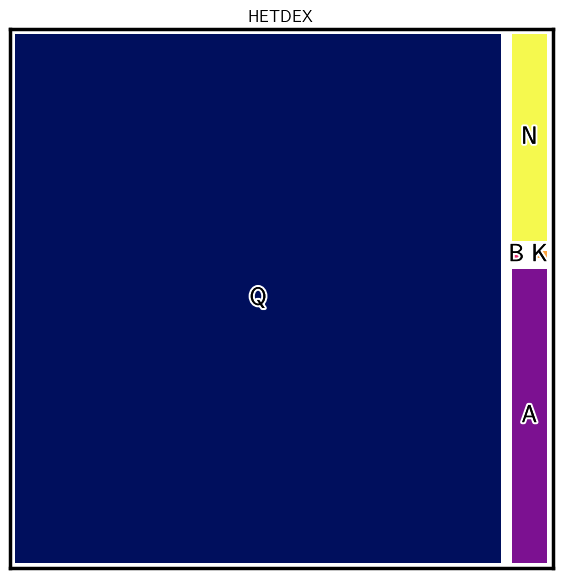

In [62]:
fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types_full_HETDEX, label=used_types_full_HETDEX, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list_HETDEX)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_title('HETDEX')
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

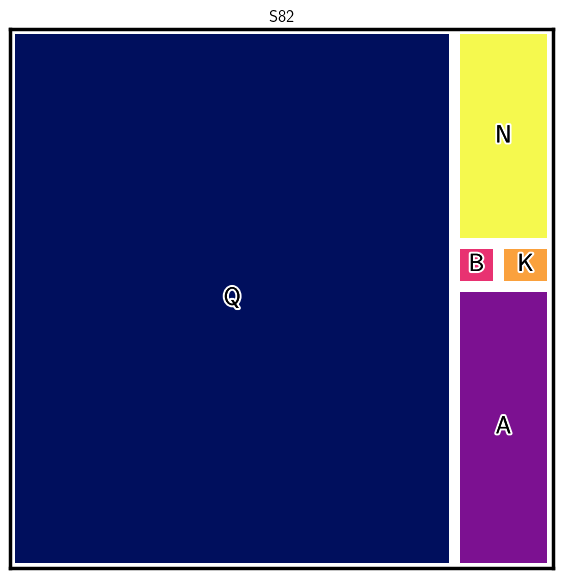

In [63]:
fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types_full_S82, label=used_types_full_S82, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list_S82)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_title('S82')
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

In [64]:
show_empty_flag = False

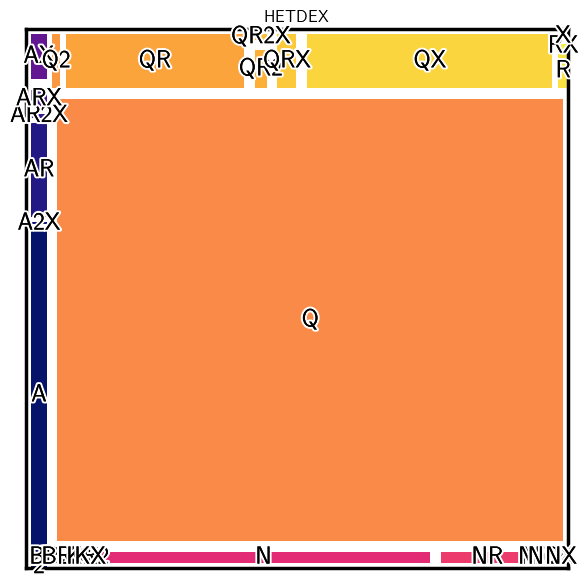

In [65]:
sizes_types   = []
list_types    = list(np.unique(full_catalog_HETDEX_df.loc[:, 'TYPE']))
if not show_empty_flag:
    list_types.remove('    ')
for type_val in list_types:
    sizes_types.append(np.sum(full_catalog_HETDEX_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)))

color_ll   = plt.get_cmap('cet_CET_L8', len(list_types))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

if show_empty_flag:
    list_types[:] = ['0   ' if x=='    ' else x for x in list_types]

fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types, label=list_types, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_title('HETDEX')
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

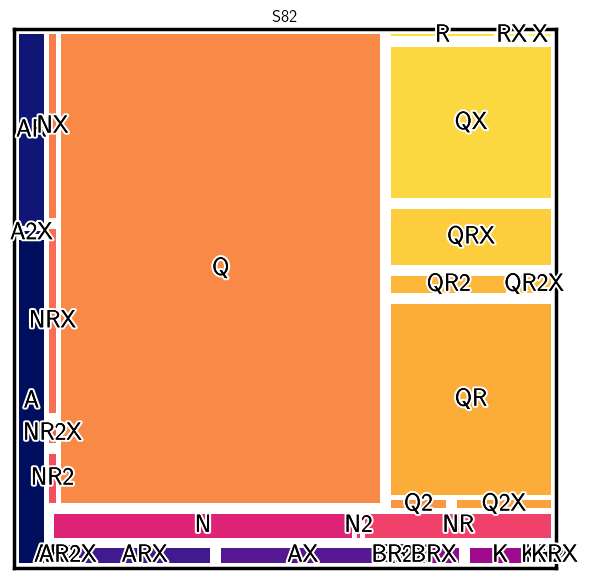

In [66]:
sizes_types   = []
list_types    = list(np.unique(full_catalog_S82_df.loc[:, 'TYPE']))
if not show_empty_flag:
    list_types.remove('    ')
for type_val in list_types:
    sizes_types.append(np.sum(full_catalog_S82_df.loc[:, 'TYPE'].str.contains(type_val, regex=False)))

color_ll   = plt.get_cmap('cet_CET_L8', len(list_types))
color_list = [mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)]

if show_empty_flag:
    list_types[:] = ['0   ' if x=='    ' else x for x in list_types]

fig             = plt.figure(figsize=(7,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

sq_plt = squarify.plot(sizes_types, label=list_types, ax=ax1, pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.tick_params(which='both', top=False, right=False, bottom=False, left=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_title('S82')
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

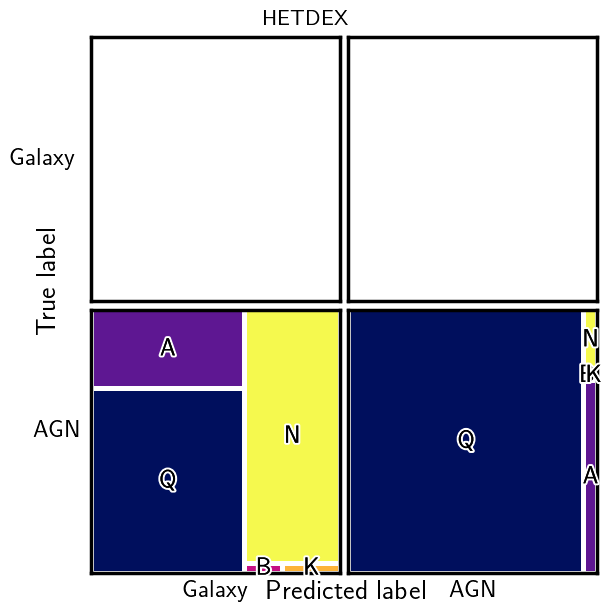

In [67]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['Q', 'A', 'B', 'L', 'K', 'N']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['Q', 'A', 'B', 'L', 'K', 'N']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(full_catalog_HETDEX_df[f'is_{type_val}'] == 1) & used_CM_filter_HETDEX[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='center', x=0.57, y=0.002)
fig.supylabel('True label', fontsize=20, va='bottom', x=0.05, y=0.45)
fig.suptitle('HETDEX', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'conf_matrix_treeplot_{used_classes}_MQC_TYPE_HETDEX_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

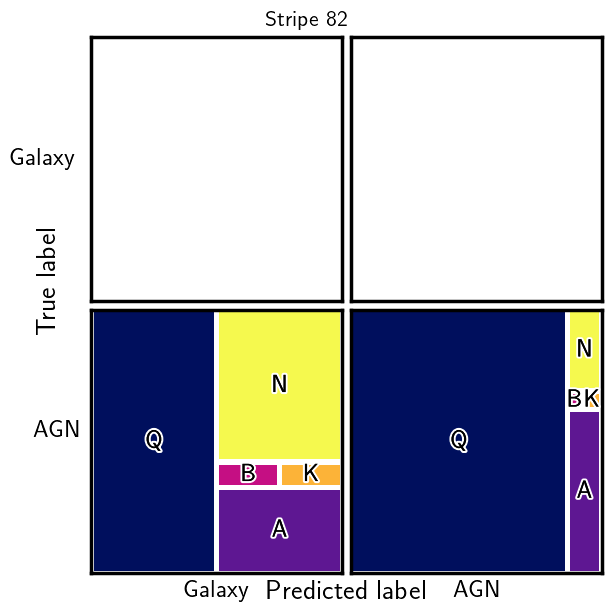

In [68]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3 * n_cols, 3 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.001, wspace=0.0)
axs             = {}

list_types    = ['Q', 'A', 'B', 'L', 'K', 'N']
color_ll      = plt.get_cmap('cet_CET_L8', len(list_types))
color_list    = {list_types[i]: mcolors.rgb2hex(color_ll(i)) for i in range(color_ll.N)}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs[count]     = fig.add_subplot(grid[count], xscale='linear', yscale='linear')
    
    list_types_tmp = ['Q', 'A', 'B', 'L', 'K', 'N']
    sizes_types    = []
    used_types     = []
    for type_val in list_types_tmp:
        n_sources  = np.sum(np.array(full_catalog_S82_df[f'is_{type_val}'] == 1) & used_CM_filter_S82[tuple(idx_ax)])
        if n_sources == 0:
            continue
        sizes_types.append(n_sources)
        used_types.append(type_val)
    
    color_list_tmp = [color_list[elem] for elem in used_types]
    
    sq_plt = squarify.plot(sizes_types, label=used_types, ax=axs[count], pad=True,\
                       text_kwargs={'fontsize': 18, 'path_effects': gf.pe2}, color=color_list_tmp)
    
    axs[count].get_xaxis().set_ticks([])
    axs[count].get_yaxis().set_ticks([])
    axs[count].tick_params(which='both', top=False, right=False,\
                           bottom=False, left=False, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

fig.supxlabel('Predicted label', fontsize=20, ha='center', x=0.57, y=0.002)
fig.supylabel('True label', fontsize=20, va='bottom', x=0.05, y=0.45)
fig.suptitle('Stripe 82', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'conf_matrix_treeplot_{used_classes}_MQC_TYPE_S82.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

### Additional plots for confusion matrix

In [69]:
mag_cols_lim = {'W1mproPM': 20.13, 'W2mproPM': 19.81, 'Sint_LOFAR': 17.52, 'Total_flux_VLASS': 15.21,\
                    'TotalFlux_LoLSS': 12.91, 'Stotal_TGSS': 11.18, 'Fint_VLAS82': 17.86,\
                    'Flux_COSMOSVLA3': 21.25, 'W1mag': 19.6, 'W2mag': 19.34, 'W3mag': 16.67,\
                    'W4mag': 14.62, 'gmag': 23.3, 'rmag': 23.2, 'imag': 23.1, 'zmag': 22.3,\
                    'ymag': 21.4, 'FUVmag': 20.0, 'NUVmag': 21.0, 'FEP': 57.9, 'Jmag': 17.45,\
                    'Hmag': 17.24, 'Kmag': 16.59}  # Proper (5-sigma) limits

for key in mag_cols_lim:
    mag_cols_lim[key] = np.float32(mag_cols_lim[key])

In [70]:
bands_plot = ['FUVmag', 'NUVmag', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag',
              'Hmag', 'Kmag', 'W1mproPM', 'W2mproPM', 'W1mag', 'W2mag', 'W3mag', 'W4mag']

In [71]:
mag_cols_names   = {'W1mproPM': 'W1 (CW)', 'W2mproPM': 'W2 (CW)', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3 (AW)', 'W4mag': 'W4 (AW)', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

Temporary plots, to obtain density maps of full dataset (all confirmed).

In [72]:
discard_imputed = False

In [73]:
mcolors.to_hex(plt.get_cmap('cet_CET_D2')(0.0))

'#39970e'

In [74]:
shade_gradient = 1.0
num            = 2
minv, maxv     = 1 - 0.1 * shade_gradient, 1 + 0.5 * shade_gradient
scales         = np.logspace(np.log(minv), np.log(maxv), num)

In [75]:
[gf.colorscale(mcolors.to_hex(plt.get_cmap('cet_CET_D2')(0.0)), scale) for scale in scales]

['#2c760a', '#90ff23']

In [76]:
# num_contour_levels = 10
# type_of_levels     = 'log'  # 'log', 'linear'
# if type_of_levels  == 'linear':
#     tmp_levs = np.linspace(3.0, 10**(np.log10(np.nanmax([np.nanmax(dens_CM_classes[key].get_array()) for
#                                                              key in dens_CM_classes if dens_CM_classes[key] != None]))), num_contour_levels)
# if type_of_levels  == 'log':
#     tmp_levs = np.logspace(np.log10(3.0), np.log10(np.nanmax([np.nanmax(dens_CM_classes[key].get_array()) for
#                                                                   key in dens_CM_classes if dens_CM_classes[key] != None])), num_contour_levels)
# tmp_levs = np.ceil(tmp_levs)
# tmp_levs = np.unique(tmp_levs)
# tmp_num_contour_levels = len(tmp_levs)
# tmp_levs[tmp_num_contour_levels - 1] -= tmp_levs[tmp_num_contour_levels - 1] % 10**np.floor(np.log10(tmp_levs[tmp_num_contour_levels - 1]))
# print(f'For the following plot, {tmp_num_contour_levels} contour levels will be located at:')
# print(tmp_levs)

In [77]:
full_dens_plot = True  # True for density plot of unknown+known only for HETDEX

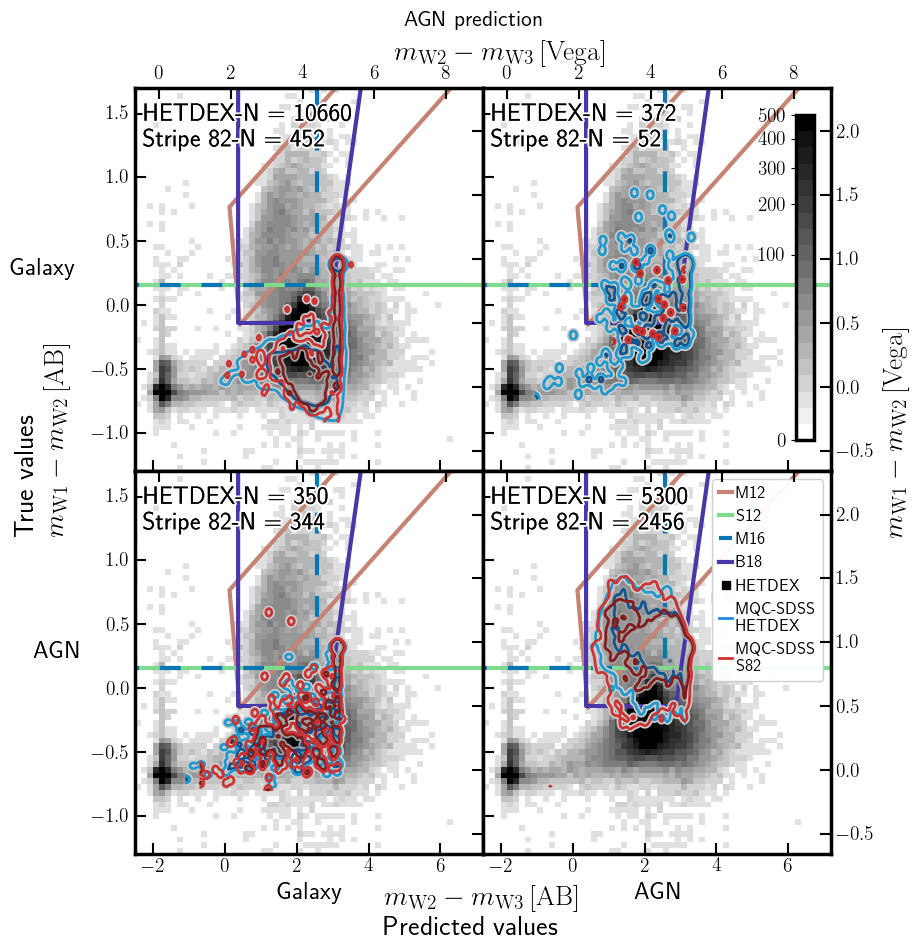

In [96]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(5 * n_cols, 5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

if discard_imputed:
    filt_colours_HETDEX    = np.array(full_catalog_HETDEX_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                      np.array(full_catalog_HETDEX_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                      np.array(full_catalog_HETDEX_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])
    filt_colours_S82    = np.array(full_catalog_S82_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                      np.array(full_catalog_S82_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                      np.array(full_catalog_S82_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])
if not discard_imputed:
    filt_colours_HETDEX    = np.ones_like(full_catalog_HETDEX_df.loc[:, 'W1mproPM']).astype(bool)
    filt_colours_S82       = np.ones_like(full_catalog_S82_df.loc[:, 'W1mproPM']).astype(bool)
    
if not full_dens_plot:
    filt_plot = np.isfinite(full_catalog_HETDEX_df.loc[:, 'W2mproPM'] - full_catalog_HETDEX_df.loc[:, 'W3mag']) &\
                np.isfinite(full_catalog_HETDEX_df.loc[:, 'W1mproPM'] - full_catalog_HETDEX_df.loc[:, 'W2mproPM'])
    
    dens_plot_data_x = (full_catalog_HETDEX_df.loc[filt_colours, 'W2mproPM'] -\
                        full_catalog_HETDEX_df.loc[filt_colours, 'W3mag'])[filt_plot]
    dens_plot_data_y = (full_catalog_HETDEX_df.loc[filt_colours, 'W1mproPM'] -\
                        full_catalog_HETDEX_df.loc[filt_colours, 'W2mproPM'])[filt_plot]
if full_dens_plot:
    merged_data    = pd.concat([full_catalog_HETDEX_df, unknown_HETDEX_df], ignore_index=True)
    filt_colours_m = np.array(merged_data.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                     np.array(merged_data.loc[:, 'W2mproPM']  != mag_cols_lim['W2mproPM']) &\
                     np.array(merged_data.loc[:, 'W3mag']     != mag_cols_lim['W3mag'])
    
    filt_plot      = np.isfinite(merged_data.loc[:, 'W2mproPM'] -
                                 merged_data.loc[:, 'W3mag']) &\
                     np.isfinite(merged_data.loc[:, 'W1mproPM'] -
                                 merged_data.loc[:, 'W2mproPM'])
    
    dens_plot_data_x = (merged_data.loc[filt_colours_m, 'W2mproPM'] -\
                        merged_data.loc[filt_colours_m, 'W3mag'])[filt_plot]
    dens_plot_data_y = (merged_data.loc[filt_colours_m, 'W1mproPM'] -\
                        merged_data.loc[filt_colours_m, 'W2mproPM'])[filt_plot]

dens_plts = {}
cont_plts = {}

x_axis_dens_AGN_HETDEX = {}
y_axis_dens_AGN_HETDEX = {}
x_axis_dens_AGN_S82 = {}
y_axis_dens_AGN_S82 = {}

AB_lims_x = (-2.5, 7.2)
AB_lims_y = (-1.3, 1.7)

# if type_of_levels  == 'linear':
#     contour_levels = np.ceil(np.linspace(3.0,\
#                                  10**(np.log10(np.nanmax([dens_CM_classes[key].get_array() for
#                                                                    key in dens_CM_classes if dens_CM_classes[key] != None]))),\
#                                  num_contour_levels))
# if type_of_levels  == 'log':
#     contour_levels = np.ceil(np.logspace(np.log10(3.0),\
#                                  np.log10(np.nanmax([dens_CM_classes[key].get_array() for
#                                                               key in dens_CM_classes if dens_CM_classes[key] != None])),\
#                                  num_contour_levels))
# contour_levels = np.unique(contour_levels)
# tmp_num_contour_levels = len(contour_levels)
# contour_levels[tmp_num_contour_levels - 1] -= contour_levels[tmp_num_contour_levels - 1] % 10**np.floor(np.log10(contour_levels[tmp_num_contour_levels - 1]))
contour_levels = [1, 1.9]  # in sigmas

num_levels_dens = 20
cmap_dens = 'cet_gray_r'
cmap_cont = 'cet_coolwarm'  # 'cet_CET_R3'
cmap_agn  = 'cet_CET_C9'

norm_val  = mcolors.CenteredNorm(vcenter=0.5)
norm_dens = ImageNormalize(vmin=0, vmax=500, stretch=PowerStretch(0.35))  # PowerStretch(0.35), LogStretch()
norm_cont = ImageNormalize(vmin=contour_levels[0], vmax=contour_levels[-1], stretch=PowerStretch(0.35)) # PowerStretch(0.35), LogStretch()

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density',\
                                          sharex=axs[0], sharey=axs[0])
    
    dens_plts[count] = axs[count].scatter_density(dens_plot_data_x,\
                                                  dens_plot_data_y,\
                                                  cmap=plt.get_cmap(cmap_dens, num_levels_dens), zorder=0, dpi=18,\
                                                  norm=norm_dens, alpha=1.0)
    # if dens_CM_classes_HETDEX[count] != None:
        # xx_agn = np.linspace(dens_CM_classes[count].get_extent()[0],\
        #                      dens_CM_classes[count].get_extent()[1], np.shape(dens_CM_classes[count].get_array())[1])
        # yy_agn = np.linspace(dens_CM_classes[count].get_extent()[2],\
        #                      dens_CM_classes[count].get_extent()[3], np.shape(dens_CM_classes[count].get_array())[0])
        # 
        # cont_plts[count] = axs[count].contour(xx_agn, yy_agn, np.flipud(dens_CM_classes[count].get_array()),\
        #                                       levels=contour_levels, linewidths=4.5, cmap=plt.get_cmap(cmap_cont),\
        #                                       linestyles='dashed', zorder=3, norm=norm_cont)
    x_axis_dens_AGN_HETDEX[count] = (full_catalog_HETDEX_df[used_CM_filter_HETDEX[tuple(idx_ax)] * filt_colours_HETDEX ]['W2mproPM'] -\
               full_catalog_HETDEX_df[used_CM_filter_HETDEX[tuple(idx_ax)] * filt_colours_HETDEX ]['W3mag'])
    y_axis_dens_AGN_HETDEX[count] = (full_catalog_HETDEX_df[used_CM_filter_HETDEX[tuple(idx_ax)] * filt_colours_HETDEX ]['W1mproPM'] -\
               full_catalog_HETDEX_df[used_CM_filter_HETDEX[tuple(idx_ax)] * filt_colours_HETDEX]['W2mproPM'])
    
    x_axis_dens_AGN_S82[count] = (full_catalog_S82_df[used_CM_filter_S82[tuple(idx_ax)] * filt_colours_S82 ]['W2mproPM'] -\
               full_catalog_S82_df[used_CM_filter_S82[tuple(idx_ax)] * filt_colours_S82]['W3mag'])
    y_axis_dens_AGN_S82[count] = (full_catalog_S82_df[used_CM_filter_S82[tuple(idx_ax)] * filt_colours_S82]['W1mproPM'] -\
               full_catalog_S82_df[used_CM_filter_S82[tuple(idx_ax)] * filt_colours_S82]['W2mproPM'])
    
    
    
    # x_Vega   = np.array(axs[0].get_xlim()) - 3.339 + 5.174  # Vega
    # y_Vega   = np.array(axs[0].get_ylim()) - 2.699 + 3.339  # Vega
    x_Vega   = np.array(AB_lims_x) - 3.339 + 5.174  # Vega
    y_Vega   = np.array(AB_lims_y) - 2.699 + 3.339  # Vega
    # Mateos+2012
    y_M12_a = 0.315 * (x_Vega) + 0.791
    y_M12_b = 0.315 * (x_Vega) - 0.222
    y_M12_c = -3.172 * (x_Vega) + 7.624
    # Stern+2012
    # Toba+2014
    # Mingo+2016
    # # Assef+2018 (75% completeness)
    # y_A18_75 = 0.530 * np.exp(0.183 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.76)**2)
    # # Assef+2018 (90% completeness)
    # y_A18_90 = 0.662 * np.exp(0.232 * (full_catalog_df.loc[filt_plot, 'W2mproPM'] - 3.339 - 13.97)**2)
    # Blecha+2018
    points_M12 = np.array([[x_Vega[-1], 1.9596, 2.2501, x_Vega[-1]], [y_M12_a[-1], 1.4083, 0.4867, y_M12_b[-1]]])
    points_M16 = np.array([[4.4, 4.4, x_Vega[0], x_Vega[0]], [y_Vega[-1], 0.8, 0.8, y_Vega[-1]]])
    points_B18 = np.array([[2.2, 2.2, 4.7, (y_Vega[-1] + 8.9) * 0.5], [y_Vega[-1], 0.5, 0.5, y_Vega[-1]]])
    
    axs[count].plot(points_M12[0] + 3.339 - 5.174, points_M12[1] + 2.699 - 3.339, label='M12',\
                    c=plt.get_cmap(cmap_agn)(0.01), zorder=1, lw=3)
    axs[count].axhline(y=0.8 + 2.699 - 3.339, label='S12', c=plt.get_cmap(cmap_agn)(0.35),\
                       zorder=1, lw=3)
    axs[count].plot(points_M16[0] + 3.339 - 5.174, points_M16[1] + 2.699 - 3.339, label='M16',\
                    c=plt.get_cmap(cmap_agn)(0.6), zorder=1, lw=3, ls=(0, (5, 5)))
    axs[count].plot(points_B18[0] + 3.339 - 5.174, points_B18[1] + 2.699 - 3.339, label='B18',\
                    c=plt.get_cmap(cmap_agn)(0.75), zorder=1, lw=3)
    
    colors_tmp = [mcolors.to_hex(plt.get_cmap(cmap_cont)(0.0)),\
                                    mcolors.to_hex(plt.get_cmap(cmap_cont)(1.0))]
    corner_white = ChainConsumer()\
    .add_chain([x_axis_dens_AGN_HETDEX[count], y_axis_dens_AGN_HETDEX[count]], parameters=['r_z', 'W1_W2'], name='HETDEX MQC AGN')\
    .add_chain([x_axis_dens_AGN_S82[count], y_axis_dens_AGN_S82[count]], parameters=['r_z', 'W1_W2'], name='Stripe 82 MQC AGN')\
    .configure(shade=False, colors='#FFFFFF', sigmas=contour_levels,\
               linewidths=4.5, shade_alpha=0.1, sigma2d=False, linestyles='-')\
    .plotter.plot_contour(ax=axs[count], parameter_x='r_z', parameter_y='W1_W2')  # Green AGN
    
    corner_color = ChainConsumer()\
    .add_chain([x_axis_dens_AGN_HETDEX[count], y_axis_dens_AGN_HETDEX[count]], parameters=['r_z', 'W1_W2'], name='HETDEX MQC AGN')\
    .add_chain([x_axis_dens_AGN_S82[count], y_axis_dens_AGN_S82[count]], parameters=['r_z', 'W1_W2'], name='Stripe 82 MQC AGN')\
    .configure(shade=False, colors=['#1E88E5', '#D32F2F'], sigmas=contour_levels,\
               linewidths=2.0, shade_alpha=0.1, sigma2d=False, linestyles='-')\
    .plotter.plot_contour(ax=axs[count], parameter_x='r_z', parameter_y='W1_W2')  # Green AGN
    n_sources_HETDEX   = np.sum(used_CM_filter_HETDEX[tuple(idx_ax)] * filt_colours_HETDEX)
    n_sources_S82   = np.sum(used_CM_filter_S82[tuple(idx_ax)] * filt_colours_S82)
    axs[count].annotate(text=f'HETDEX-N = {n_sources_HETDEX}\nStripe 82-N = {n_sources_S82}', xy=(0.02, 0.96), xycoords='axes fraction', fontsize=18,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    
    
    axs_twinx[count] = axs[count].twinx()
    # axs_twinx[count].set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339))
    # axs_twinx[count].set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
    axs_twinx[count].tick_params(which='both', top=False, right=True, direction='in')
    axs_twinx[count].tick_params(which='both', bottom=False, left=False, direction='in')
    axs_twinx[count].tick_params(axis='both', which='major', labelsize=14)
    axs_twinx[count].tick_params(which='major', length=8, width=1.5)
    axs_twinx[count].tick_params(which='minor', length=4, width=1.5)
    # axs_twinx[count].set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20)
    
    axs_twiny[count] = axs[count].twiny()
    # axs_twiny[count].set_xlim(tuple(np.array(ax1.get_xlim()) - 3.339 + 5.174))
    # axs_twiny[count].set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
    axs_twiny[count].tick_params(which='both', top=True, right=False, direction='in')
    axs_twiny[count].tick_params(which='both', bottom=False, left=False, direction='in')
    axs_twiny[count].tick_params(axis='both', which='major', labelsize=14)
    axs_twiny[count].tick_params(which='major', length=8, width=1.5)
    axs_twiny[count].tick_params(which='minor', length=4, width=1.5)
    # axs_twiny[count].set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20)

    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)

# Colorbar density
axins0 = inset_axes(axs[1], width='100%', height='100%', bbox_transform=axs[1].transAxes,\
                    loc=1, bbox_to_anchor=(0.9, 0.08, 0.05, 0.85), borderpad=0)

clb_dens    = fig.colorbar(dens_plts[1], cax=axins0, orientation='vertical',\
                 cmap=plt.get_cmap(cmap_dens, num_levels_dens), norm=norm_dens)
axins0.yaxis.set_ticks_position('left')
clb_dens.ax.tick_params(labelsize=14)
clb_dens.outline.set_linewidth(2.5)
# clb_dens.ax.set_ylabel('Elements per pixel', size=12, path_effects=pe2)
##

# Colorbar contour
# axins1 = inset_axes(axs[3], width='100%', height='100%', bbox_transform=axs[3].transAxes,\
#                     loc=1, bbox_to_anchor=(0.9, 0.08, 0.05, 0.85), borderpad=0)
# sm = plt.cm.ScalarMappable(norm=norm_cont, cmap=cont_plts[3].cmap)
# sm.set_array([])
# clb_cont    = fig.colorbar(sm, cax=axins1, orientation='vertical', ticks=cont_plts[3].levels)
# axins1.yaxis.set_ticks_position('left')
# clb_cont.ax.tick_params(labelsize=11)
# clb_cont.outline.set_linewidth(2.5)
##
    
axs[3].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap(cmap_dens)(1.1), label='HETDEX', zorder=0)
axs[3].plot([-3], [-3], marker=None, ls='-', lw=2.0, c='#1E88E5', label='MQC-SDSS\nHETDEX', zorder=0)
axs[3].plot([-3], [-3], marker=None, ls='-', lw=2.0, c='#D32F2F', label='MQC-SDSS\nS82', zorder=0)
    
axs[0].set_xlim(left=AB_lims_x[0], right=AB_lims_x[1])
axs[0].set_ylim(bottom=AB_lims_y[0], top=AB_lims_y[1])
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)

plt.setp(axs_twiny[2].get_xticklabels(), visible=False)
plt.setp(axs_twiny[3].get_xticklabels(), visible=False)

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    axs_twinx[count].set_ylim(tuple(np.array(axs[0].get_ylim()) - 2.699 + 3.339))
    axs_twiny[count].set_xlim(tuple(np.array(axs[0].get_xlim()) - 3.339 + 5.174))

axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

axs_twinx[1].set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=20, y=0.10)
axs_twiny[0].set_xlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[Vega]}$', size=20, x=1.05)

axs[3].legend(loc=1, fontsize=12, ncol=1, columnspacing=.5, handletextpad=0.2, handlelength=0.8, framealpha=0.95)

fig.supxlabel('$m_{\mathrm{W2}} - m_{\mathrm{W3}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.46, y=0.05)
fig.supylabel('True values\n$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$', fontsize=20, x=0.09, y=0.55, va='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.55)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'WISE_colour_colour_conf_matrix_{used_classes}_HETDEX_{HETDEX_subset}_S82_{S82_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

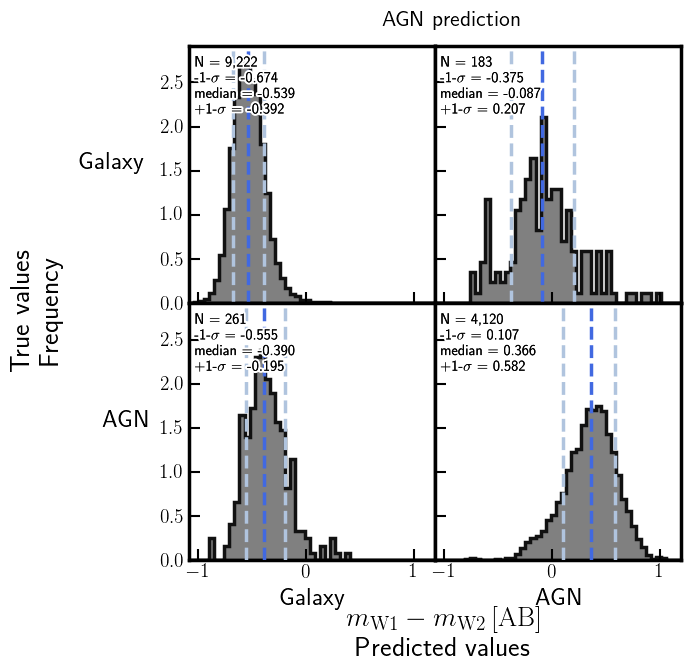

In [90]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

filt_colours = np.array(full_catalog_HETDEX_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_HETDEX_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_HETDEX_df.loc[:, 'W3mag'] != mag_cols_lim['W3mag'])

filt_colour  = np.array(full_catalog_HETDEX_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_HETDEX_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM'])

filt_plot = np.isfinite(full_catalog_HETDEX_df.loc[:, 'W2mproPM'] - full_catalog_HETDEX_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_HETDEX_df.loc[:, 'W1mproPM'] - full_catalog_HETDEX_df.loc[:, 'W2mproPM'])


min_bin   = (full_catalog_HETDEX_df.loc[:, 'W1mproPM'] -\
             full_catalog_HETDEX_df.loc[:, 'W2mproPM']).min()
max_bin   = (full_catalog_HETDEX_df.loc[:, 'W1mproPM'] -\
             full_catalog_HETDEX_df.loc[:, 'W2mproPM']).max()
n_bins    = 50
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_HETDEX_df.loc[used_CM_filter_HETDEX[tuple(idx_ax)] * filt_plot * filt_colour, 'W1_W2']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True)
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'W1_W2_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'W1_W2_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

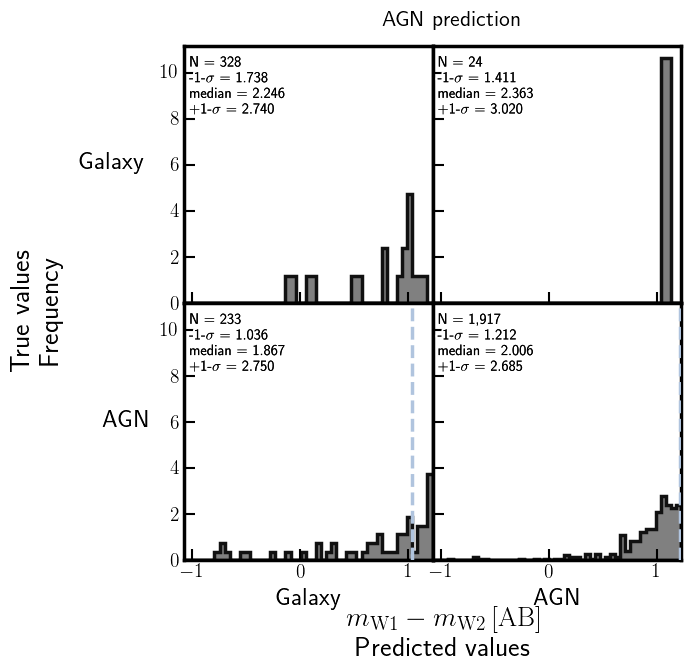

In [93]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

filt_colours = np.array(full_catalog_S82_df.loc[:, 'W1mproPM']  != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_S82_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                np.array(full_catalog_S82_df.loc[:, 'W3mag']    != mag_cols_lim['W3mag'])

filt_colour  = np.array(full_catalog_S82_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                np.array(full_catalog_S82_df.loc[:, 'W2mproPM']!= mag_cols_lim['W2mproPM'])

filt_plot = np.isfinite(full_catalog_S82_df.loc[:, 'W2mproPM'] - full_catalog_S82_df.loc[:, 'W3mag']) &\
            np.isfinite(full_catalog_S82_df.loc[:, 'W1mproPM'] - full_catalog_S82_df.loc[:, 'W2mproPM'])


min_bin   = (full_catalog_S82_df.loc[:, 'W1mproPM'] -\
             full_catalog_S82_df.loc[:, 'W2mproPM']).min()
max_bin   = (full_catalog_S82_df.loc[:, 'W1mproPM'] -\
             full_catalog_S82_df.loc[:, 'W2mproPM']).max()
n_bins    = 50
hist_bins = np.linspace(min_bin, max_bin, n_bins)


dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_S82_df.loc[used_CM_filter_S82[tuple(idx_ax)] * filt_plot * filt_colour, 'W2_W3']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True)
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.02, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='left', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'W2_W3_hist_conf_matrix_AGN_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'W2_W3_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

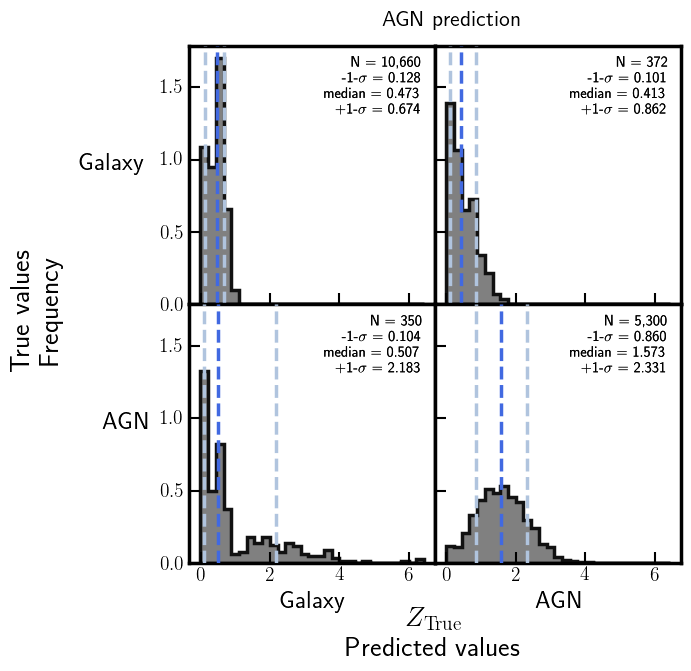

In [94]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

min_bin   = full_catalog_HETDEX_df.loc[:, 'Z'].min()
max_bin   = full_catalog_HETDEX_df.loc[:, 'Z'].max()
n_bins    = 30
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_HETDEX_df.loc[used_CM_filter_HETDEX[tuple(idx_ax)], 'Z']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True, align='mid')
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.96, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='right', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
# axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$Z_{\mathrm{True}}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'redshift_hist_conf_matrix_{used_classes}_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'redshift_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

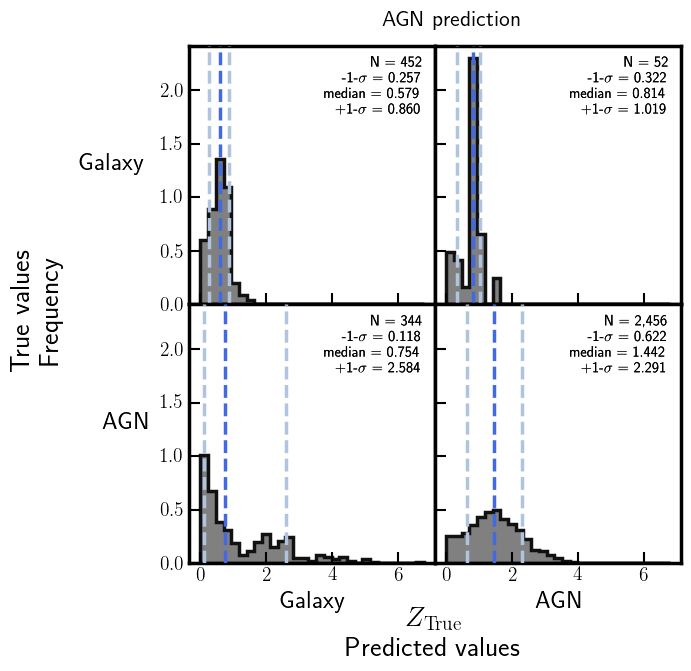

In [95]:
n_rows = 2
n_cols = 2

fig             = plt.figure(figsize=(3.5 * n_cols, 3.5 * n_rows), constrained_layout=True)

grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,\
                                   height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
axs             = {}
axs_twinx       = {}
axs_twiny       = {}

min_bin   = full_catalog_S82_df.loc[:, 'Z'].min()
max_bin   = full_catalog_S82_df.loc[:, 'Z'].max()
n_bins    = 30
hist_bins = np.linspace(min_bin, max_bin, n_bins)

dens_plts = {}
cont_plts = {}
hist_plts = {}

for count, idx_ax in enumerate(np.array([[0, 0], [0, 1], [1, 0], [1, 1]])):
    # axs[count] = fig.add_subplot(grid[tuple(idx_ax)], projection='scatter_density')
    
    if count == 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)], xscale='linear', yscale='linear')
    if count != 0:
        axs[count] = fig.add_subplot(grid[tuple(idx_ax)],\
                                          sharex=axs[0], sharey=axs[0], xscale='linear', yscale='linear')
        
    data_to_plot     = full_catalog_S82_df.loc[used_CM_filter_S82[tuple(idx_ax)], 'Z']
    
    hist_plts[count] = axs[count].hist(data_to_plot, bins=hist_bins, histtype='stepfilled',\
                                       fc='grey', ec='k', lw=2.5, density=True, align='mid')
    
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [15.9]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [50.0]), ls='--', lw=2.5, c='royalblue', zorder=10)
    axs[count].axvline(x=np.nanpercentile(data_to_plot, [84.1]), ls='--', lw=2.5, c='lightsteelblue', zorder=10)
    
    n_sources        = np.sum(np.isfinite(data_to_plot))
    if n_sources != 0:
        summ_text = f'N = {n_sources:,}\n-1-$\sigma$ = {np.nanpercentile(data_to_plot, [15.9])[0]:.3f}\n' +\
                    f'median = {np.nanpercentile(data_to_plot, [50.0])[0]:.3f}\n' +\
                    f'+1-$\sigma$ = {np.nanpercentile(data_to_plot, [84.1])[0]:.3f}'
        
        axs[count].annotate(text=summ_text, xy=(0.96, 0.96), xycoords='axes fraction', fontsize=11,\
                            ha='right', va='top', path_effects=gf.pe2, zorder=11)
    
    axs[count].tick_params(which='both', top=False, right=False,\
                            bottom=True, left=True, direction='in')
    axs[count].tick_params(axis='both', which='major', labelsize=14)
    axs[count].tick_params(axis='both', which='minor', labelsize=14)
    axs[count].tick_params(which='major', length=8, width=1.5)
    axs[count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    plt.setp(axs[count].spines.values(), linewidth=2.5)
    
    
# axs[1].plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap('cet_gray_r')(1.1), label='CW', zorder=0)
# axs[1].plot([-3], [-3], marker=None, ls='--', c=plt.get_cmap('cet_CET_L8')(0.0), label='MQC', zorder=0)
    
# axs[0].set_xlim(left=min_bin, right=max_bin)
# axs[0].set_ylim(bottom=-1.3, top=1.7)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[3].get_yticklabels(), visible=False)


axs[0].set_ylabel(used_labels[used_classes][0], fontsize=18, rotation='horizontal', labelpad=35)
axs[2].set_xlabel(used_labels[used_classes][0], fontsize=18)
axs[2].set_ylabel(used_labels[used_classes][1], fontsize=18, rotation='horizontal', labelpad=25)
axs[3].set_xlabel(used_labels[used_classes][1], fontsize=18)

# axs[1].legend(loc=4, fontsize=14, ncol=3, columnspacing=.5, handletextpad=0.2, handlelength=0.8)

fig.supxlabel('$Z_{\mathrm{True}}$\nPredicted values', fontsize=20, ha='left', x=0.5, y=0.05, ma='center')
fig.supylabel('True values\nFrequency', fontsize=20,  y=0.55, ma='center')
fig.suptitle(f'{used_classes} prediction', fontsize=16, x=0.65)
fig.tight_layout()
if save_plot_flag:
    save_filename = f'redshift_hist_conf_matrix_{used_classes}_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'redshift_hist_conf_matrix_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

In [86]:
cm_mat_AGN_radio_det_HETDEX = np.array([[np.sum(used_CM_filter_HETDEX[tuple([0, 0])] * np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_HETDEX[tuple([0, 0])]),\
                                  np.sum(used_CM_filter_HETDEX[tuple([0, 1])] * np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_HETDEX[tuple([0, 1])])],\
                                 [np.sum(used_CM_filter_HETDEX[tuple([1, 0])] * np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_HETDEX[tuple([1, 0])]),\
                                  np.sum(used_CM_filter_HETDEX[tuple([1, 1])] * np.array(full_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_HETDEX[tuple([1, 1])])]])

cm_mat_AGN_radio_det_S82 = np.array([[np.sum(used_CM_filter_S82[tuple([0, 0])] * np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_S82[tuple([0, 0])]),\
                                  np.sum(used_CM_filter_S82[tuple([0, 1])] * np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_S82[tuple([0, 1])])],\
                                 [np.sum(used_CM_filter_S82[tuple([1, 0])] * np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_S82[tuple([1, 0])]),\
                                  np.sum(used_CM_filter_S82[tuple([1, 1])] * np.array(full_catalog_S82_df.loc[:, 'LOFAR_detect'] == 1)) /\
                                  np.sum(used_CM_filter_S82[tuple([1, 1])])]])

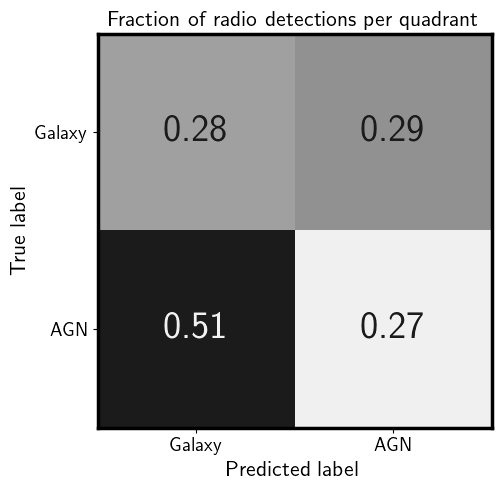

In [87]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_AGN_radio_det_HETDEX, 'Fraction of radio detections per quadrant', ax1,\
                 display_labels=used_labels[used_classes])
# Format numbers in cells
for text in _.texts:
    text.set_text(f'{float(text.get_text()):.2f}')

if save_plot_flag:
    save_filename = f'confusion_matrix_radio_fraction_{used_classes}_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'confusion_matrix_radio_fraction_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()

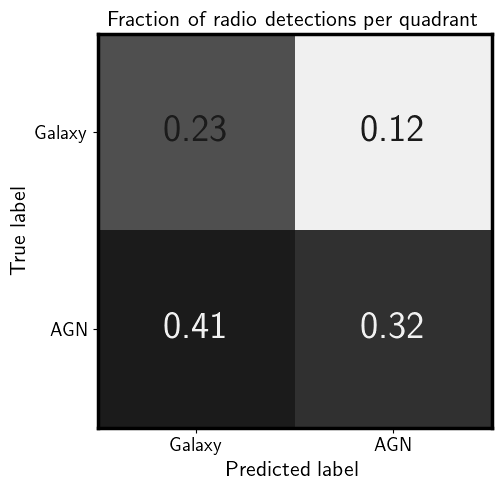

In [88]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_AGN_radio_det_S82, 'Fraction of radio detections per quadrant', ax1,\
                 display_labels=used_labels[used_classes])
# Format numbers in cells
for text in _.texts:
    text.set_text(f'{float(text.get_text()):.2f}')

if save_plot_flag:
    save_filename = f'confusion_matrix_radio_fraction_{used_classes}_{used_area}.pdf'
    if used_area == 'HETDEX':
        save_filename = f'confusion_matrix_radio_fraction_{used_classes}_{used_area}_{HETDEX_subset}.pdf'
    plt.savefig(gv.plots_path + save_filename, bbox_inches='tight')
plt.show()